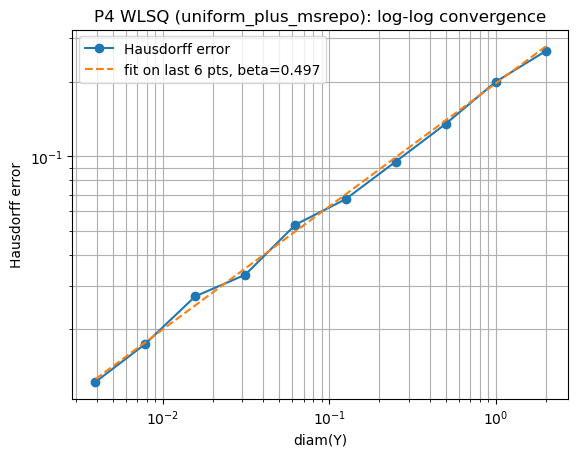

Estimated beta = 0.497246550183072
Repo sizes: {'P4_s1': 10, 'P4_s2': 1}


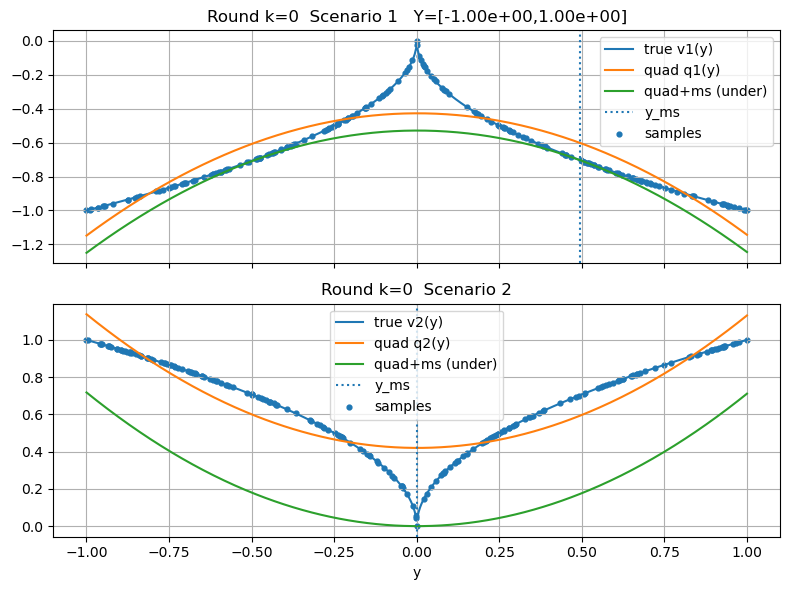

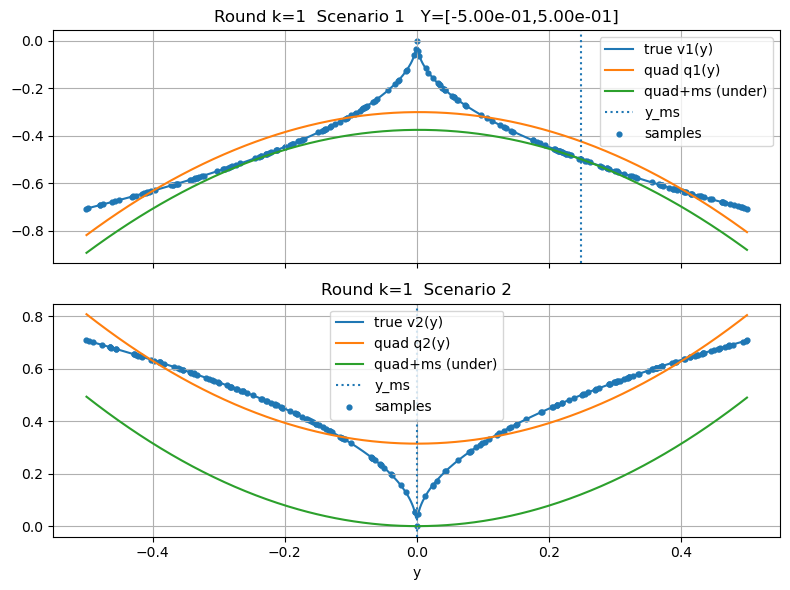

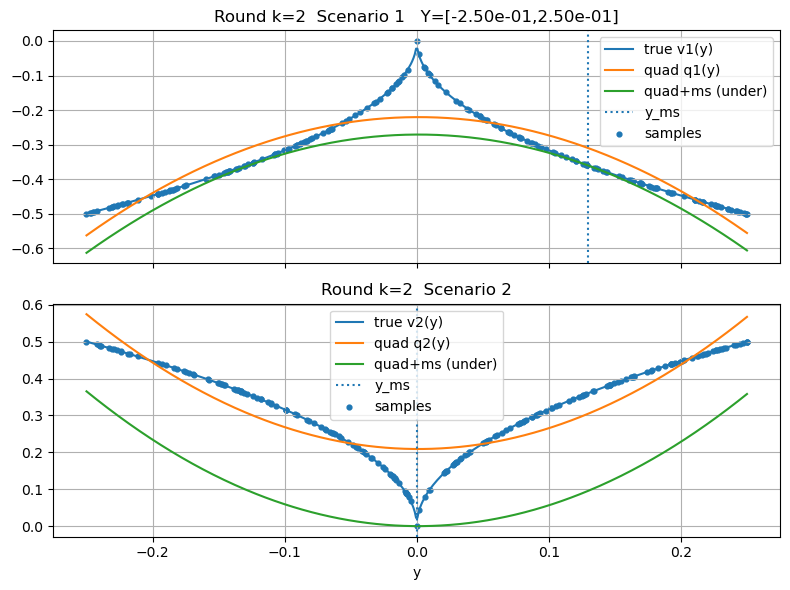

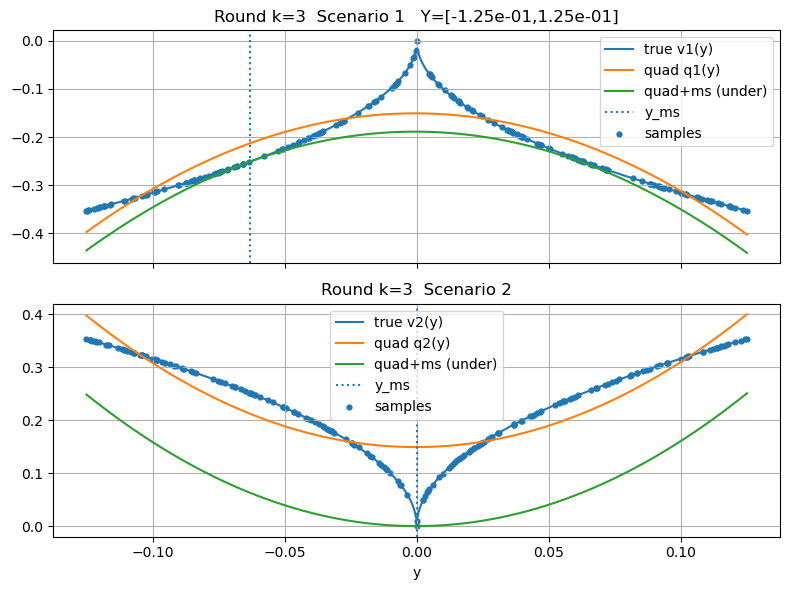

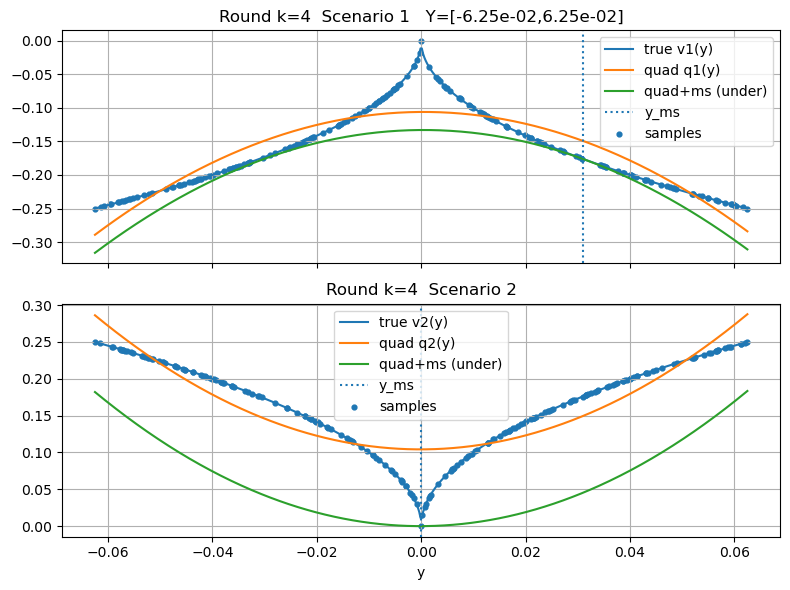

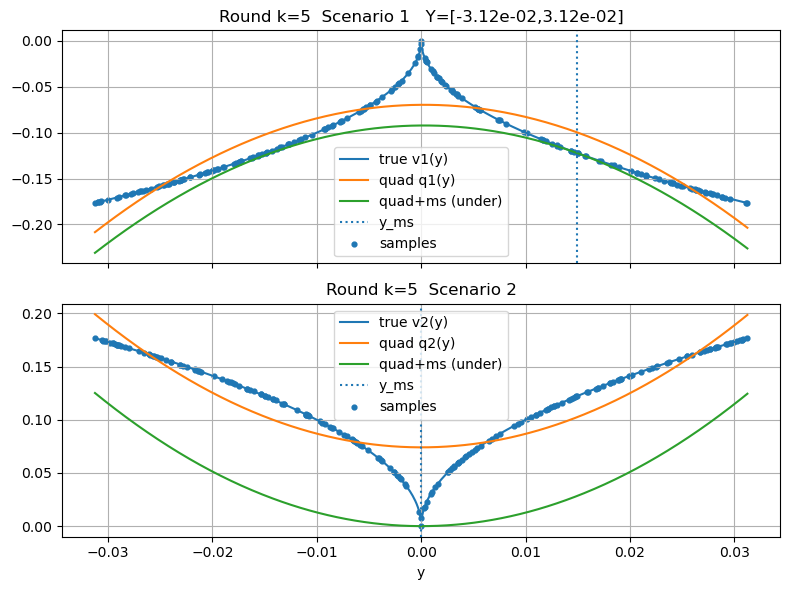

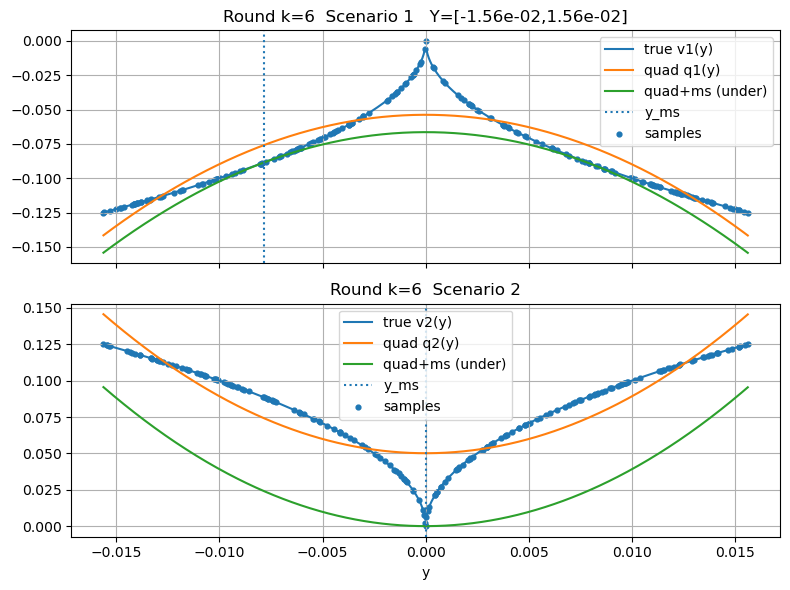

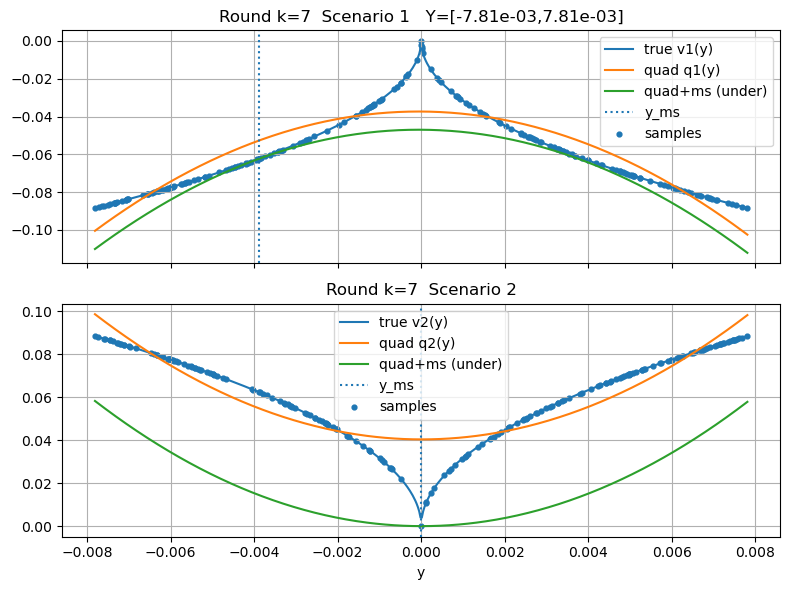

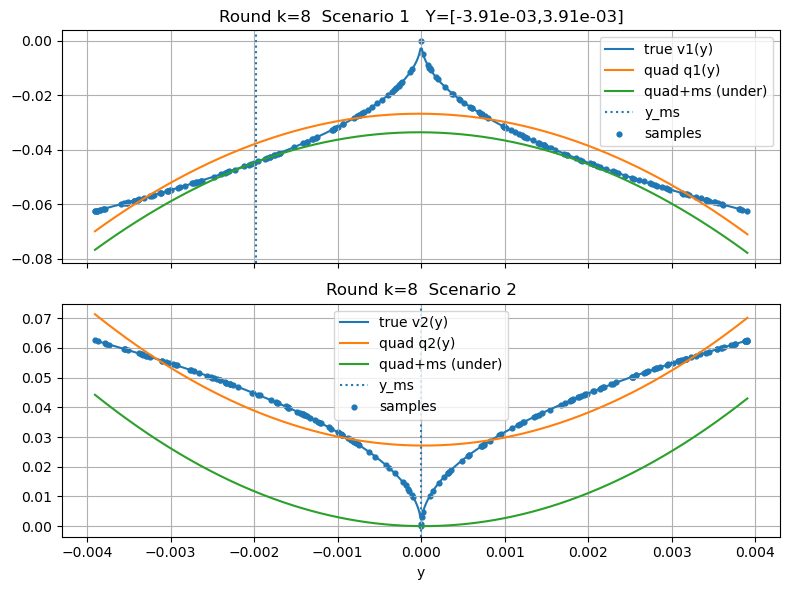

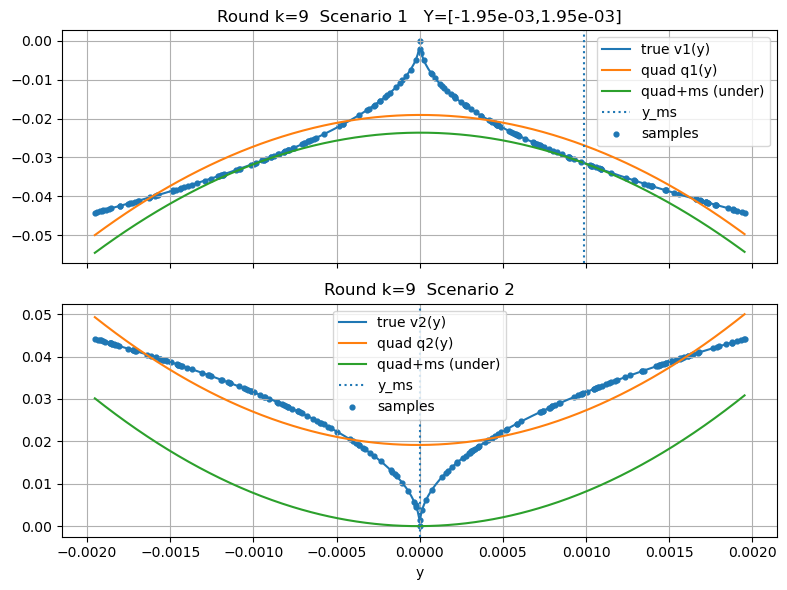

In [3]:
# ============================================================
# P4 (non-Lipschitz) + WLSQ + Hausdorff error convergence order
# + Per-iteration plots:
#   For each k, for each scenario:
#     - true v(y)
#     - fitted quadratic q(y)
#     - shifted underestimator q(y)+ms
# ============================================================

import numpy as np
from dataclasses import dataclass, field
from typing import Callable, Tuple, Dict, List, Optional
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt


# -------------------------
# P4 true scenario value functions
# -------------------------
def v1(y: float) -> float:
    return -np.sqrt(abs(y))

def v2(y: float) -> float:
    return +np.sqrt(abs(y))

P1 = 0.5
P2 = 0.5


# -------------------------
# MS point repository (per scenario)
# -------------------------
@dataclass
class MSPointRepo:
    points: Dict[str, List[float]] = field(default_factory=dict)
    tol: float = 1e-10

    def add(self, key: str, y: float):
        lst = self.points.setdefault(key, [])
        for yy in lst:
            if abs(yy - y) <= self.tol:
                return
        lst.append(float(y))

    def get_in_interval(self, key: str, Y: Tuple[float, float]) -> np.ndarray:
        lo, hi = Y
        lst = self.points.get(key, [])
        if not lst:
            return np.array([], dtype=float)
        arr = np.array(lst, dtype=float)
        return arr[(arr >= lo) & (arr <= hi)]


# -------------------------
# Quadratic model + diagnostic
# -------------------------
@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float  # shift
    y_ms: float  # argmin point of (v-q) i.e. argmax of (q-v)

    def q(self, y: float) -> float:
        return self.a * y * y + self.b * y + self.c

    def under(self, y: float) -> float:
        return self.q(y) + self.ms


@dataclass
class FitDiag:
    ys: np.ndarray
    fs: np.ndarray
    w: np.ndarray


# -------------------------
# Weighted least squares fit: q(y)=a y^2 + b y + c
# -------------------------
def fit_weighted_quadratic(y: np.ndarray, f: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    y = np.asarray(y, dtype=float).ravel()
    f = np.asarray(f, dtype=float).ravel()
    w = np.asarray(w, dtype=float).ravel()
    assert y.shape == f.shape == w.shape

    X = np.vstack([y**2, y, np.ones_like(y)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))
    Xw = X * W[:, None]
    fw = f * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    a, b, c = coef.tolist()
    return a, b, c


# -------------------------
# Exact shift to make underestimator on Y
# Returns (ms, y_ms)
# -------------------------
def exact_shift_to_underestimator(
    v: Callable[[float], float],
    a: float, b: float, c: float,
    Y: Tuple[float, float],
) -> Tuple[float, float]:
    lo, hi = Y
    assert lo <= 0 <= hi

    def q(y): return a*y*y + b*y + c
    def h(y): return q(y) - v(y)  # maximize

    cand = [lo, 0.0, hi]
    best_val = -np.inf
    best_y = 0.0
    for y in cand:
        val = h(y)
        if val > best_val:
            best_val = float(val)
            best_y = float(y)

    for (L, U) in [(lo, 0.0), (0.0, hi)]:
        if U - L <= 0:
            continue
        res = minimize_scalar(lambda t: -h(t), bounds=(L, U), method="bounded")
        if res.success:
            val = h(res.x)
            if val > best_val:
                best_val = float(val)
                best_y = float(res.x)

    ms = -best_val
    y_ms = best_y
    return ms, y_ms


# -------------------------
# Build WLSQ underestimator
# NEW: "uniform_plus_msrepo" adds historical ms points (extra, not counted in n_samples)
# Returns (QuadModel, FitDiag)
# -------------------------
def build_wlsq_underestimator(
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    weight_mode: str = "uniform",
    ms_repo: Optional[MSPointRepo] = None,
    scenario_key: Optional[str] = None,
) -> Tuple[QuadModel, FitDiag]:
    lo, hi = Y

    # base samples: include endpoints and 0, then random to reach ~n_samples
    fixed = np.array([lo, 0.0, hi], dtype=float)
    m = max(n_samples - len(fixed), 0)
    ys_rand = rng.uniform(lo, hi, size=m) if m > 0 else np.array([], dtype=float)
    ys = np.concatenate([fixed, ys_rand])

    # extra points from ms repo
    if weight_mode == "uniform_plus_msrepo":
        if ms_repo is None or scenario_key is None:
            raise ValueError("weight_mode='uniform_plus_msrepo' requires ms_repo and scenario_key.")
        extra = ms_repo.get_in_interval(scenario_key, Y)
        if extra.size > 0:
            ys = np.concatenate([ys, extra])

    # de-dup for stability
    ys = np.unique(ys)

    fs = np.array([v(float(t)) for t in ys])

    # weights
    if weight_mode in ("uniform", "uniform_plus_msrepo"):
        w = np.ones_like(fs)
    elif weight_mode == "near_zero_focus":
        sigma = 0.25 * (hi - lo)
        sigma = max(sigma, 1e-12)
        w = np.exp(-(ys**2) / (2.0 * sigma**2))
    elif weight_mode == "low_value_focus":
        alpha = 5.0
        w = np.exp(-alpha * (fs - fs.min()))
    else:
        raise ValueError(f"Unknown weight_mode={weight_mode}")

    a, b, c = fit_weighted_quadratic(ys, fs, w)
    ms, y_ms = exact_shift_to_underestimator(v, a, b, c, Y)

    if ms_repo is not None and scenario_key is not None:
        ms_repo.add(scenario_key, y_ms)

    model = QuadModel(a=a, b=b, c=c, ms=ms, y_ms=y_ms)
    diag = FitDiag(ys=ys, fs=fs, w=w)
    return model, diag


# -------------------------
# Compute min of quadratic on interval
# -------------------------
def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b / (2.0 * a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    return float(min(vals))


# -------------------------
# Hausdorff error for interval Y
# true min v(y)=0, relaxation min is LB(Y) <= 0, so error = -LB(Y)
# -------------------------
def hausdorff_error_for_interval(Y: Tuple[float, float], m1: QuadModel, m2: QuadModel) -> Tuple[float, float]:
    lo, hi = Y
    a = P1 * m1.a + P2 * m2.a
    b = P1 * m1.b + P2 * m2.b
    c = P1 * (m1.c + m1.ms) + P2 * (m2.c + m2.ms)
    lb = min_of_quadratic_on_interval(a, b, c, lo, hi)
    err = -lb
    return lb, err


# -------------------------
# Experiment runner (stores per-iteration models/diags for plotting)
# -------------------------
def run_p4_experiment(
    eps0: float = 1.0,
    rho: float = 0.5,
    n_levels: int = 14,
    n_samples: int = 300,
    seed: int = 1,
    weight_mode: str = "uniform_plus_msrepo",
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)
    ms_repo = MSPointRepo()

    eps_list, diam_list, lb_list, err_list = [], [], [], []
    rounds = []  # store per k: {Y, m1, m2, d1, d2}

    for k in range(n_levels):
        eps = eps0 * (rho ** k)
        Y = (-eps, eps)

        m1, d1 = build_wlsq_underestimator(
            v1, Y, n_samples=n_samples, rng=rng,
            weight_mode=weight_mode, ms_repo=ms_repo, scenario_key="P4_s1"
        )
        m2, d2 = build_wlsq_underestimator(
            v2, Y, n_samples=n_samples, rng=rng,
            weight_mode=weight_mode, ms_repo=ms_repo, scenario_key="P4_s2"
        )

        lb, err = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0 * eps)
        lb_list.append(lb)
        err_list.append(err)

        rounds.append(dict(k=k, Y=Y, m1=m1, m2=m2, d1=d1, d2=d2))

    return {
        "eps": np.array(eps_list),
        "diam": np.array(diam_list),
        "lb": np.array(lb_list),
        "err": np.array(err_list),
        "ms_repo": ms_repo,
        "rounds": rounds,
        "weight_mode": weight_mode,
        "seed": seed,
        "n_samples": n_samples,
    }


def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    lx = np.log(x)
    ly = np.log(y)
    beta, _ = np.polyfit(lx, ly, deg=1)
    return float(beta)


def plot_convergence(out: Dict[str, object], slope_fit_last: int = 8, title: Optional[str] = None) -> float:
    diam = out["diam"]
    err = out["err"]
    mask = (diam > 0) & (err > 0)
    diam = diam[mask]
    err = err[mask]

    K = min(slope_fit_last, len(diam))
    beta = estimate_slope_loglog(diam[-K:], err[-K:])

    lx = np.log(diam[-K:])
    ly = np.log(err[-K:])
    c = float(np.mean(ly - beta * lx))
    fit_err = np.exp(beta * np.log(diam) + c)

    plt.figure()
    plt.loglog(diam, err, marker="o", linestyle="-", label="Hausdorff error")
    plt.loglog(diam, fit_err, linestyle="--", label=f"fit on last {K} pts, beta={beta:.3f}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    if title is None:
        title = f"P4 WLSQ ({out['weight_mode']}): log-log convergence"
    plt.title(title)
    plt.legend()
    plt.show()

    return beta


# -------------------------
# Per-iteration plotting (two scenarios in one figure)
# -------------------------
def plot_round_scenarios(round_info: Dict[str, object], n_grid: int = 400, show_samples: bool = True):
    k = round_info["k"]
    lo, hi = round_info["Y"]

    m1: QuadModel = round_info["m1"]
    m2: QuadModel = round_info["m2"]
    d1: FitDiag = round_info["d1"]
    d2: FitDiag = round_info["d2"]

    ys = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    # Scenario 1
    ax = axes[0]
    ax.plot(ys, np.array([v1(float(t)) for t in ys]), label="true v1(y)")
    ax.plot(ys, np.array([m1.q(float(t)) for t in ys]), label="quad q1(y)")
    ax.plot(ys, np.array([m1.under(float(t)) for t in ys]), label="quad+ms (under)")

    # mark y_ms
    ax.axvline(m1.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d1.ys, d1.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k}  Scenario 1   Y=[{lo:.2e},{hi:.2e}]")
    ax.legend()

    # Scenario 2
    ax = axes[1]
    ax.plot(ys, np.array([v2(float(t)) for t in ys]), label="true v2(y)")
    ax.plot(ys, np.array([m2.q(float(t)) for t in ys]), label="quad q2(y)")
    ax.plot(ys, np.array([m2.under(float(t)) for t in ys]), label="quad+ms (under)")

    ax.axvline(m2.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d2.ys, d2.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k}  Scenario 2")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()


# ============================================================
# RUN (edit parameters here)
# ============================================================
params = dict(
    eps0=1.0,
    rho=0.5,
    n_levels=10,                 # 每一轮都画图的话建议先设小一点，比如 8~12
    n_samples=200,
    seed=1,
    weight_mode="uniform_plus_msrepo",  # "uniform" / "uniform_plus_msrepo" / "near_zero_focus" / "low_value_focus"
)

out = run_p4_experiment(**params)

# 1) 收敛图
beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)
print("Repo sizes:", {k: len(v) for k, v in out["ms_repo"].points.items()})

# 2) 每一轮画两个场景：原函数 / 二次拟合 / 二次+ms
for r in out["rounds"]:
    plot_round_scenarios(r, n_grid=500, show_samples=True)


P1

In [11]:
# ============================================================
# P1 (Smooth) + WLSQ + Hausdorff error convergence order
# + Per-iteration plots:
#   For each k, for each scenario:
#     - true v_omega(y)
#     - fitted quadratic q_omega(y)
#     - shifted underestimator q_omega(y)+ms
# + Final log-log convergence plot of Hausdorff error vs diam(Y)
# ============================================================

import numpy as np
from dataclasses import dataclass, field
from typing import Callable, Tuple, Dict, List, Optional
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt


# -------------------------
# P1 true value functions (from the paper)
# Domain: y in [1, 20], minimizer y* = 10
# -------------------------
def v_total(y: float) -> float:
    return 0.005 * (y - 10.0) ** 2

def v1(y: float) -> float:
    return 0.0025 * (y - 10.0) ** 2 + np.sqrt(y)

def v2(y: float) -> float:
    return 0.0025 * (y - 10.0) ** 2 - np.sqrt(y)

P1 = 0.5
P2 = 0.5

YBAR = (1.0, 20.0)
YSTAR = 10.0


# -------------------------
# MS point repository (per scenario)
# -------------------------
@dataclass
class MSPointRepo:
    points: Dict[str, List[float]] = field(default_factory=dict)
    tol: float = 1e-10

    def add(self, key: str, y: float):
        lst = self.points.setdefault(key, [])
        for yy in lst:
            if abs(yy - y) <= self.tol:
                return
        lst.append(float(y))

    def get_in_interval(self, key: str, Y: Tuple[float, float]) -> np.ndarray:
        lo, hi = Y
        lst = self.points.get(key, [])
        if not lst:
            return np.array([], dtype=float)
        arr = np.array(lst, dtype=float)
        return arr[(arr >= lo) & (arr <= hi)]


# -------------------------
# Quadratic model + diagnostics
# -------------------------
@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float
    y_ms: float  # argmin of (v-q) (equivalently argmax of (q-v))

    def q(self, y: float) -> float:
        return self.a * y * y + self.b * y + self.c

    def under(self, y: float) -> float:
        return self.q(y) + self.ms


@dataclass
class FitDiag:
    ys: np.ndarray
    fs: np.ndarray
    w: np.ndarray


# -------------------------
# Weighted least squares fit: q(y)=a y^2 + b y + c
# -------------------------
def fit_weighted_quadratic(y: np.ndarray, f: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    y = np.asarray(y, dtype=float).ravel()
    f = np.asarray(f, dtype=float).ravel()
    w = np.asarray(w, dtype=float).ravel()
    assert y.shape == f.shape == w.shape

    X = np.vstack([y**2, y, np.ones_like(y)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))
    Xw = X * W[:, None]
    fw = f * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    a, b, c = coef.tolist()
    return a, b, c


# -------------------------
# Exact shift to make underestimator on Y
# Returns (ms, y_ms) where ms = min_{y in Y} (v(y)-q(y))
# Implemented via maximizing h(y)=q(y)-v(y) on Y.
# -------------------------
def exact_shift_to_underestimator(
    v: Callable[[float], float],
    a: float, b: float, c: float,
    Y: Tuple[float, float],
) -> Tuple[float, float]:
    lo, hi = Y

    def q(y): return a*y*y + b*y + c
    def h(y): return q(y) - v(y)  # maximize

    # start from endpoints + midpoint (helps for smooth case)
    mid = 0.5 * (lo + hi)
    cand = [lo, mid, hi]

    best_val = -np.inf
    best_y = mid
    for y in cand:
        val = h(y)
        if val > best_val:
            best_val = float(val)
            best_y = float(y)

    # maximize h on [lo,hi] by minimizing -h
    res = minimize_scalar(lambda t: -h(t), bounds=(lo, hi), method="bounded")
    if res.success:
        val = h(res.x)
        if val > best_val:
            best_val = float(val)
            best_y = float(res.x)

    ms = -best_val
    y_ms = best_y
    return ms, y_ms


# -------------------------
# Build WLSQ underestimator with weight_mode
# NEW: "uniform_plus_msrepo" adds historical ms points (extra, not counted in n_samples)
# -------------------------
def build_wlsq_underestimator(
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    weight_mode: str = "uniform_plus_msrepo",
    ms_repo: Optional[MSPointRepo] = None,
    scenario_key: Optional[str] = None,
) -> Tuple[QuadModel, FitDiag]:
    lo, hi = Y

    # base samples: include endpoints + center, then random to reach ~n_samples
    fixed = np.array([lo, 0.5*(lo+hi), hi], dtype=float)
    m = max(n_samples - len(fixed), 0)
    ys_rand = rng.uniform(lo, hi, size=m) if m > 0 else np.array([], dtype=float)
    ys = np.concatenate([fixed, ys_rand])

    # extra ms-repo points
    if weight_mode == "uniform_plus_msrepo":
        if ms_repo is None or scenario_key is None:
            raise ValueError("weight_mode='uniform_plus_msrepo' requires ms_repo and scenario_key.")
        extra = ms_repo.get_in_interval(scenario_key, Y)
        if extra.size > 0:
            ys = np.concatenate([ys, extra])

    ys = np.unique(ys)
    fs = np.array([v(float(t)) for t in ys])

    # weights
    if weight_mode in ("uniform", "uniform_plus_msrepo"):
        w = np.ones_like(fs)
    elif weight_mode == "near_center_focus":
        # emphasize around the interval center (for P1, y* is in the center)
        center = 0.5 * (lo + hi)
        sigma = 0.25 * (hi - lo)
        sigma = max(sigma, 1e-12)
        w = np.exp(-((ys - center) ** 2) / (2.0 * sigma**2))
    elif weight_mode == "low_value_focus":
        # emphasize low function values
        alpha = 5.0
        w = np.exp(-alpha * (fs - fs.min()))
    else:
        raise ValueError(f"Unknown weight_mode={weight_mode}")

    a, b, c = fit_weighted_quadratic(ys, fs, w)
    ms, y_ms = exact_shift_to_underestimator(v, a, b, c, Y)

    if ms_repo is not None and scenario_key is not None:
        ms_repo.add(scenario_key, y_ms)

    model = QuadModel(a=a, b=b, c=c, ms=ms, y_ms=y_ms)
    diag = FitDiag(ys=ys, fs=fs, w=w)
    return model, diag


# -------------------------
# Min of quadratic on [lo,hi]
# -------------------------
def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b / (2.0 * a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    return float(min(vals))


# -------------------------
# Hausdorff error on Y:
#   err(Y) = min_Y v(y) - min_Y vhat(y)
# For P1 with Y centered at 10, min_Y v(y) = 0 (attained at y=10).
# -------------------------
def hausdorff_error_for_interval(Y: Tuple[float, float], m1: QuadModel, m2: QuadModel) -> Tuple[float, float]:
    lo, hi = Y

    # aggregated underestimator is quadratic:
    a = P1*m1.a + P2*m2.a
    b = P1*m1.b + P2*m2.b
    c = P1*(m1.c + m1.ms) + P2*(m2.c + m2.ms)

    lb = min_of_quadratic_on_interval(a, b, c, lo, hi)  # <= 0
    true_min = 0.0
    err = true_min - lb
    return lb, err


# -------------------------
# Run experiment + store per-iteration plots data
# -------------------------
def run_p1_experiment(
    eps0: float = 1.0,
    rho: float = 0.5,
    n_levels: int = 12,
    n_samples: int = 300,
    seed: int = 1,
    weight_mode: str = "uniform_plus_msrepo",
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)
    ms_repo = MSPointRepo()

    eps_list, diam_list, lb_list, err_list = [], [], [], []
    rounds = []

    for k in range(n_levels):
        eps = eps0 * (rho ** k)
        Y = (YSTAR - eps, YSTAR + eps)

        # keep within [1,20]
        if Y[0] < YBAR[0] or Y[1] > YBAR[1]:
            raise ValueError(f"Interval {Y} out of domain {YBAR}. Reduce eps0 or n_levels.")

        m1, d1 = build_wlsq_underestimator(
            v1, Y, n_samples=n_samples, rng=rng,
            weight_mode=weight_mode, ms_repo=ms_repo, scenario_key="P1_s1"
        )
        m2, d2 = build_wlsq_underestimator(
            v2, Y, n_samples=n_samples, rng=rng,
            weight_mode=weight_mode, ms_repo=ms_repo, scenario_key="P1_s2"
        )

        lb, err = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0 * eps)
        lb_list.append(lb)
        err_list.append(err)

        rounds.append(dict(k=k, Y=Y, m1=m1, m2=m2, d1=d1, d2=d2))

    return {
        "eps": np.array(eps_list),
        "diam": np.array(diam_list),
        "lb": np.array(lb_list),
        "err": np.array(err_list),
        "ms_repo": ms_repo,
        "rounds": rounds,
        "weight_mode": weight_mode,
        "seed": seed,
        "n_samples": n_samples,
    }


def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    beta, _ = np.polyfit(np.log(x), np.log(y), deg=1)
    return float(beta)


def plot_convergence(out: Dict[str, object], slope_fit_last: int = 8, title: Optional[str] = None) -> float:
    diam = out["diam"]
    err = out["err"]

    mask = (diam > 0) & (err > 0)
    diam = diam[mask]
    err = err[mask]

    K = min(slope_fit_last, len(diam))
    beta = estimate_slope_loglog(diam[-K:], err[-K:])

    # fitted line using last K points
    lx = np.log(diam[-K:])
    ly = np.log(err[-K:])
    c = float(np.mean(ly - beta * lx))
    fit_err = np.exp(beta * np.log(diam) + c)

    plt.figure()
    plt.loglog(diam, err, marker="o", linestyle="-", label="Hausdorff error")
    plt.loglog(diam, fit_err, linestyle="--", label=f"fit on last {K} pts, beta={beta:.3f}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    if title is None:
        title = f"P1 WLSQ ({out['weight_mode']}): log-log convergence"
    plt.title(title)
    plt.legend()
    plt.show()

    return beta


# -------------------------
# Per-iteration plot: each round show scenario 1 and 2
# Each subplot includes:
#   true v_omega, quad q_omega, quad+ms, y_ms, and sample points
# -------------------------
def plot_round_scenarios(round_info: Dict[str, object], n_grid: int = 500, show_samples: bool = True):
    k = round_info["k"]
    lo, hi = round_info["Y"]

    m1: QuadModel = round_info["m1"]
    m2: QuadModel = round_info["m2"]
    d1: FitDiag = round_info["d1"]
    d2: FitDiag = round_info["d2"]

    ys = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    # Scenario 1
    ax = axes[0]
    ax.plot(ys, np.array([v1(float(t)) for t in ys]), label="true v1(y)")
    ax.plot(ys, np.array([m1.q(float(t)) for t in ys]), label="quad q1(y)")
    ax.plot(ys, np.array([m1.under(float(t)) for t in ys]), label="quad+ms (under)")
    ax.axvline(m1.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d1.ys, d1.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k}  Scenario 1   Y=[{lo:.6f},{hi:.6f}]")
    ax.legend()

    # Scenario 2
    ax = axes[1]
    ax.plot(ys, np.array([v2(float(t)) for t in ys]), label="true v2(y)")
    ax.plot(ys, np.array([m2.q(float(t)) for t in ys]), label="quad q2(y)")
    ax.plot(ys, np.array([m2.under(float(t)) for t in ys]), label="quad+ms (under)")
    ax.axvline(m2.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d2.ys, d2.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k}  Scenario 2")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()


# ============================================================
# RUN (edit parameters here)
# ============================================================
params = dict(
    eps0=1.0,                 # Y0 = [9,11] (matches the paper's illustrative interval)
    rho=0.5,                  # shrink rate
    n_levels=10,              # 每轮都画图建议先 8~12
    n_samples=1,
    seed=1,
    weight_mode="uniform_plus_msrepo",  # "uniform" / "uniform_plus_msrepo" / "near_center_focus" / "low_value_focus"
)

out = run_p1_experiment(**params)

# 1) Convergence plot (Hausdorff error vs diam(Y))
beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)
print("Repo sizes:", {k: len(v) for k, v in out["ms_repo"].points.items()})

# 2) Per-iteration plots
for r in out["rounds"]:
    plot_round_scenarios(r, n_grid=600, show_samples=True)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_302008\4097918592.py:328: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_302008\4097918592.py:377: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Estimated beta = 2.999941813967671
Repo sizes: {'P1_s1': 10, 'P1_s2': 10}


P2

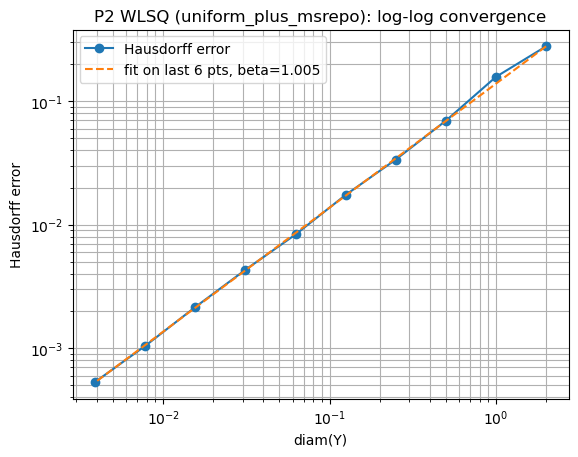

Estimated beta = 1.0048951159729773
Repo sizes: {'P2_s1': 10, 'P2_s2': 10}


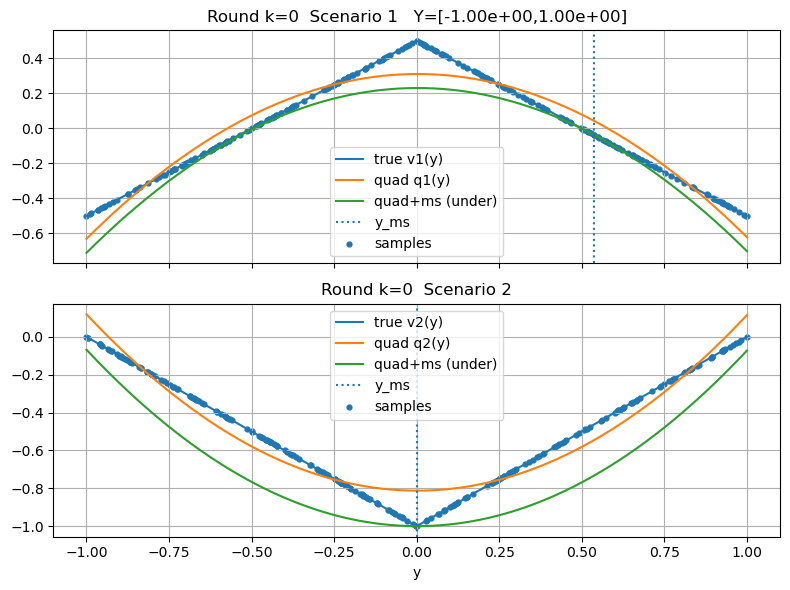

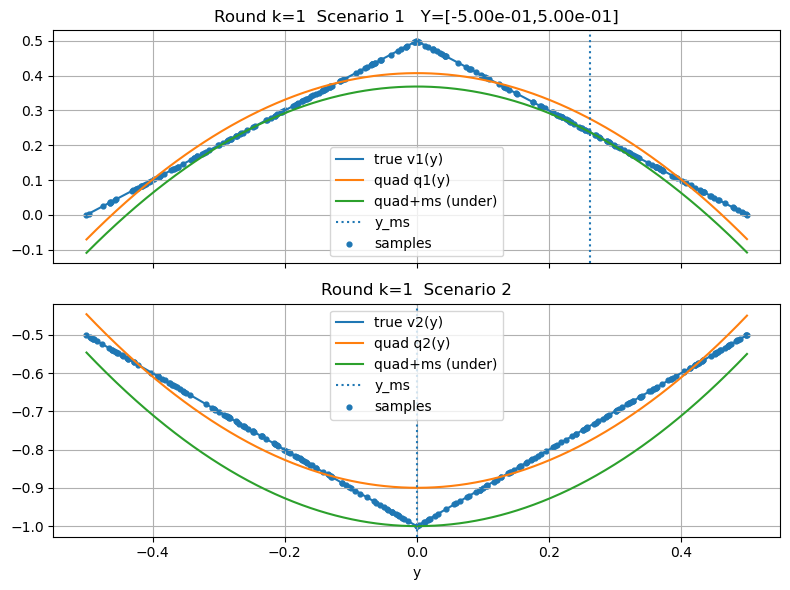

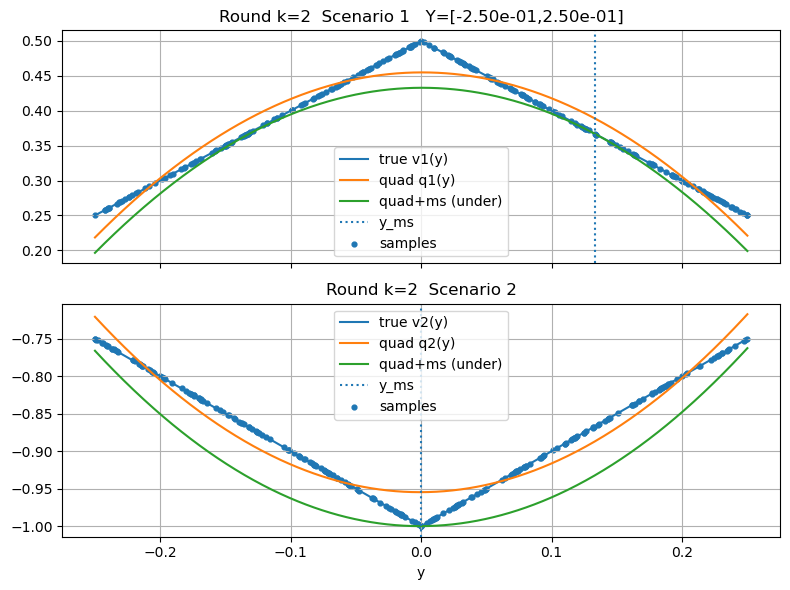

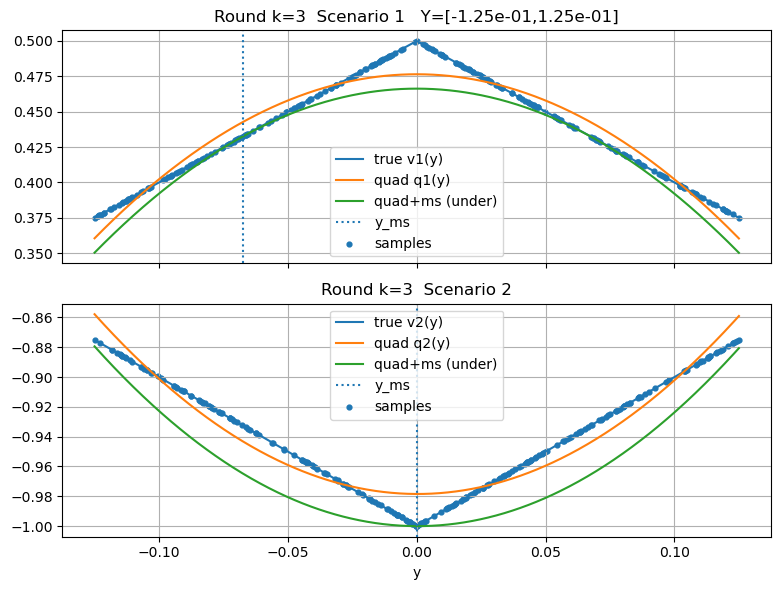

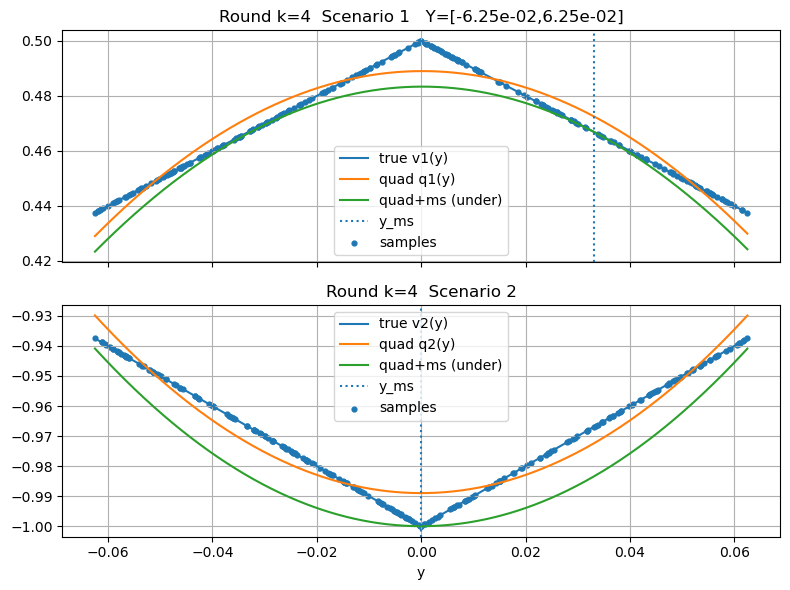

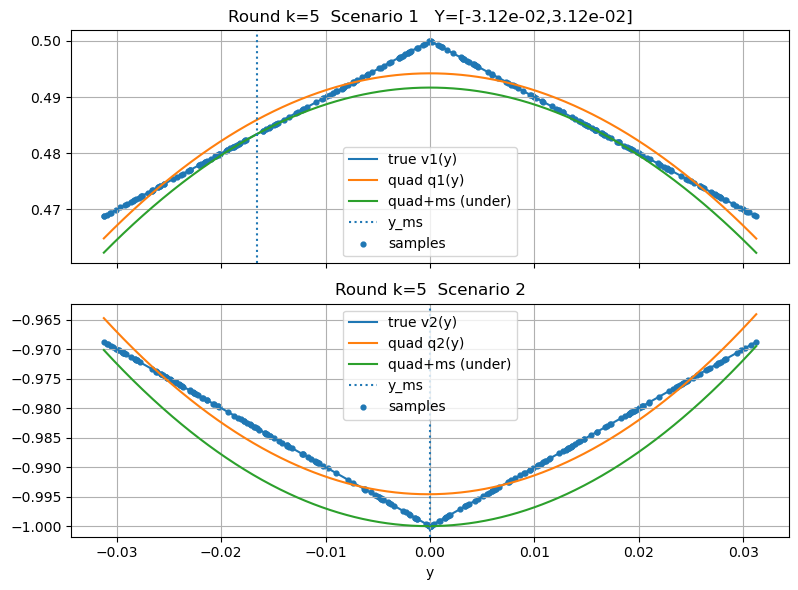

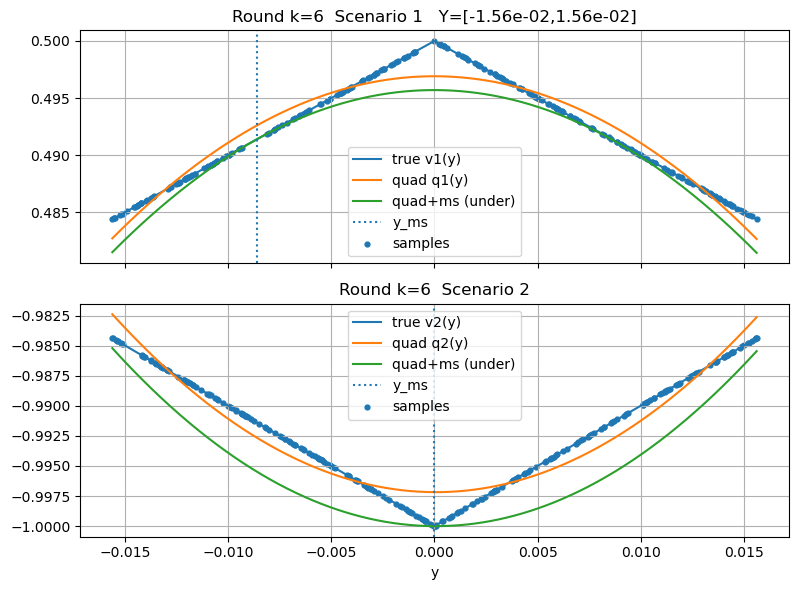

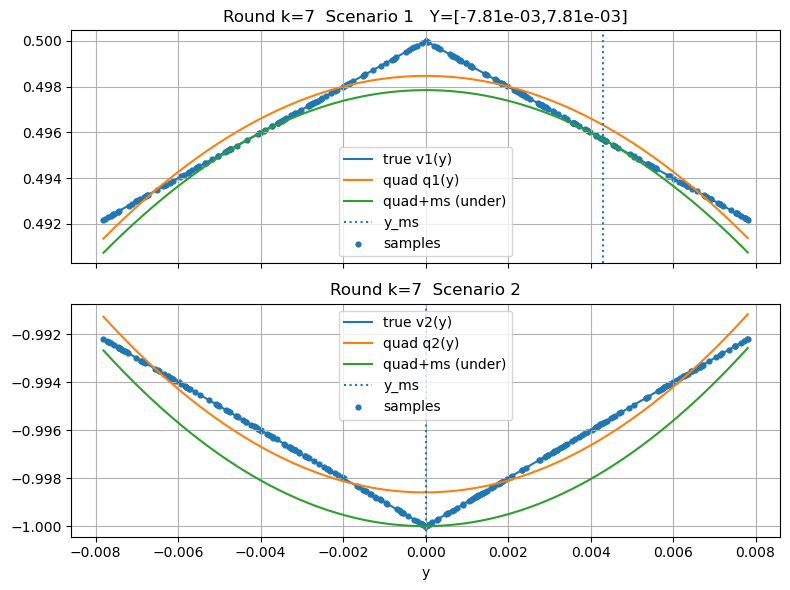

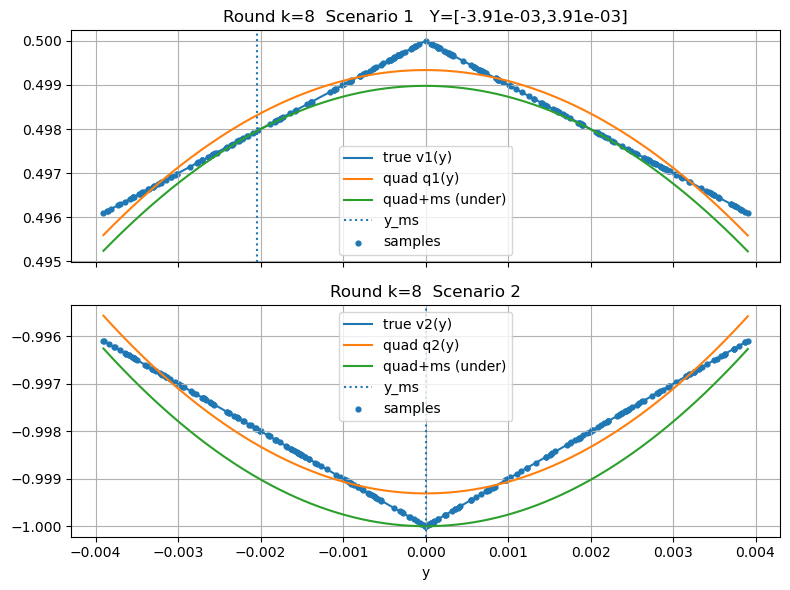

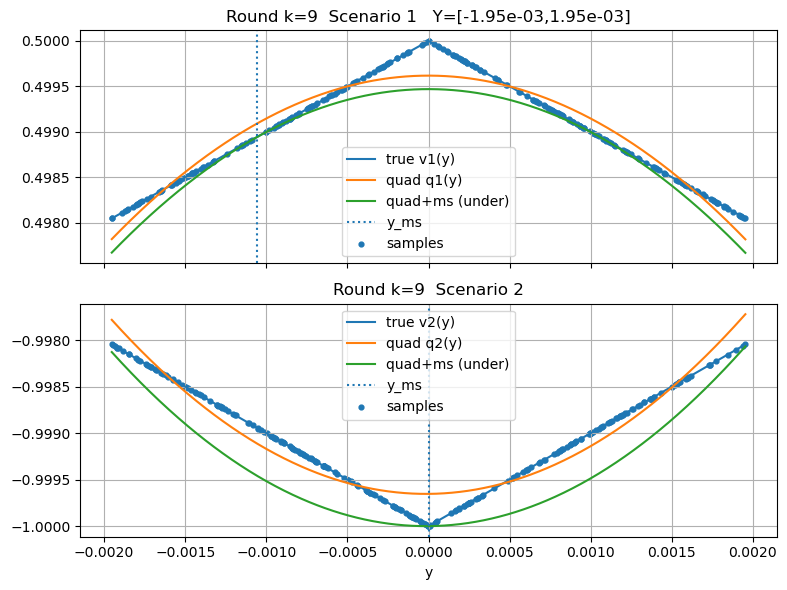

In [7]:
# ============================================================
# P2 (Lipschitz but nonsmooth) + WLSQ + Hausdorff error order
# (FIXED): total value function uses v = v1 + v2 (NOT average)
# + Per-iteration plots (two scenarios, each with true / q / q+ms)
# + Final log-log convergence plot of Hausdorff error vs diam(Y)
# ============================================================

import numpy as np
from dataclasses import dataclass, field
from typing import Callable, Tuple, Dict, List, Optional
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt


# -------------------------
# P2 value functions (paper):
# v1(y) = -|y| + 1/2,  v2(y) = |y| - 1,  total v(y) = v1(y) + v2(y) = -1/2
# -------------------------
def v1(y: float) -> float:
    return -abs(y) + 0.5

def v2(y: float) -> float:
    return abs(y) - 1.0

def v_total(y: float) -> float:
    return v1(y) + v2(y)  # == -0.5 (constant)

# IMPORTANT: total = sum, so weights are 1 and 1 (not 0.5 and 0.5)
P1 = 1.0
P2 = 1.0

YSTAR = 0.0


# -------------------------
# MS point repository (per scenario)
# -------------------------
@dataclass
class MSPointRepo:
    points: Dict[str, List[float]] = field(default_factory=dict)
    tol: float = 1e-10

    def add(self, key: str, y: float):
        lst = self.points.setdefault(key, [])
        for yy in lst:
            if abs(yy - y) <= self.tol:
                return
        lst.append(float(y))

    def get_in_interval(self, key: str, Y: Tuple[float, float]) -> np.ndarray:
        lo, hi = Y
        lst = self.points.get(key, [])
        if not lst:
            return np.array([], dtype=float)
        arr = np.array(lst, dtype=float)
        return arr[(arr >= lo) & (arr <= hi)]


# -------------------------
# Quadratic model + diagnostics
# -------------------------
@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float
    y_ms: float

    def q(self, y: float) -> float:
        return self.a * y * y + self.b * y + self.c

    def under(self, y: float) -> float:
        return self.q(y) + self.ms


@dataclass
class FitDiag:
    ys: np.ndarray
    fs: np.ndarray
    w: np.ndarray


# -------------------------
# Weighted LS fit: q(y)=a y^2 + b y + c
# -------------------------
def fit_weighted_quadratic(y: np.ndarray, f: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    y = np.asarray(y, dtype=float).ravel()
    f = np.asarray(f, dtype=float).ravel()
    w = np.asarray(w, dtype=float).ravel()
    assert y.shape == f.shape == w.shape

    X = np.vstack([y**2, y, np.ones_like(y)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))
    Xw = X * W[:, None]
    fw = f * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    a, b, c = coef.tolist()
    return a, b, c


# -------------------------
# Exact shift to make underestimator on Y (split at 0 due to nonsmoothness)
# ms = min_{y in Y}(v(y)-q(y))  =>  q+ms <= v on Y
# -------------------------
def exact_shift_to_underestimator(
    v: Callable[[float], float],
    a: float, b: float, c: float,
    Y: Tuple[float, float],
    safety_grid: int = 5000,
    safety_tol: float = 1e-12,
) -> Tuple[float, float]:
    lo, hi = Y
    assert lo <= 0 <= hi

    def q(y): return a*y*y + b*y + c
    def h(y): return q(y) - v(y)  # maximize

    # initial candidates
    cand = [lo, 0.0, hi]
    best_val = -np.inf
    best_y = 0.0
    for y in cand:
        val = h(y)
        if val > best_val:
            best_val = float(val)
            best_y = float(y)

    # local searches on both sides
    for (L, U) in [(lo, 0.0), (0.0, hi)]:
        if U - L <= 0:
            continue
        res = minimize_scalar(lambda t: -h(t), bounds=(L, U), method="bounded")
        if res.success:
            val = h(res.x)
            if val > best_val:
                best_val = float(val)
                best_y = float(res.x)

    ms = -best_val
    y_ms = best_y

    # safety correction (dense grid) to avoid tiny numerical violation
    ys = np.linspace(lo, hi, safety_grid)
    vv = np.array([v(float(t)) for t in ys])
    viol = np.max((a*ys*ys + b*ys + c + ms) - vv)
    if viol > safety_tol:
        ms -= (viol + safety_tol)

    # refresh y_ms from grid (optional)
    hs = (a*ys*ys + b*ys + c) - vv
    y_ms = float(ys[int(np.argmax(hs))])

    return ms, y_ms


# -------------------------
# Build WLSQ underestimator
# weight_mode:
#   - "uniform"
#   - "uniform_plus_msrepo" (adds historical ms points, extra beyond n_samples)
#   - "near_zero_focus"
#   - "low_value_focus"
# -------------------------
def build_wlsq_underestimator(
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    weight_mode: str = "uniform_plus_msrepo",
    ms_repo: Optional[MSPointRepo] = None,
    scenario_key: Optional[str] = None,
) -> Tuple[QuadModel, FitDiag]:
    lo, hi = Y

    fixed = np.array([lo, 0.0, hi], dtype=float)
    m = max(n_samples - len(fixed), 0)
    ys_rand = rng.uniform(lo, hi, size=m) if m > 0 else np.array([], dtype=float)
    ys = np.concatenate([fixed, ys_rand])

    if weight_mode == "uniform_plus_msrepo":
        if ms_repo is None or scenario_key is None:
            raise ValueError("weight_mode='uniform_plus_msrepo' requires ms_repo and scenario_key.")
        extra = ms_repo.get_in_interval(scenario_key, Y)
        if extra.size > 0:
            ys = np.concatenate([ys, extra])

    ys = np.unique(ys)
    fs = np.array([v(float(t)) for t in ys])

    if weight_mode in ("uniform", "uniform_plus_msrepo"):
        w = np.ones_like(fs)
    elif weight_mode == "near_zero_focus":
        sigma = 0.25 * (hi - lo)
        sigma = max(sigma, 1e-12)
        w = np.exp(-(ys**2) / (2.0 * sigma**2))
    elif weight_mode == "low_value_focus":
        alpha = 5.0
        w = np.exp(-alpha * (fs - fs.min()))
    else:
        raise ValueError(f"Unknown weight_mode={weight_mode}")

    a, b, c = fit_weighted_quadratic(ys, fs, w)
    ms, y_ms = exact_shift_to_underestimator(v, a, b, c, Y)

    if ms_repo is not None and scenario_key is not None:
        ms_repo.add(scenario_key, y_ms)

    model = QuadModel(a=a, b=b, c=c, ms=ms, y_ms=y_ms)
    diag = FitDiag(ys=ys, fs=fs, w=w)
    return model, diag


# -------------------------
# Min of quadratic on [lo,hi]
# -------------------------
def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b / (2.0 * a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    return float(min(vals))


# -------------------------
# Hausdorff error on Y:
# err(Y) = min_Y v_total(y) - min_Y vhat_total(y)
# Here v_total(y) == -0.5 (constant), so true_min = -0.5
# -------------------------
def hausdorff_error_for_interval(Y: Tuple[float, float], m1: QuadModel, m2: QuadModel) -> Tuple[float, float]:
    lo, hi = Y

    # total underestimator = sum of scenario underestimators (weights 1,1)
    a = P1*m1.a + P2*m2.a
    b = P1*m1.b + P2*m2.b
    c = P1*(m1.c + m1.ms) + P2*(m2.c + m2.ms)

    lb = min_of_quadratic_on_interval(a, b, c, lo, hi)
    true_min = -0.5
    err = true_min - lb
    return lb, err


# -------------------------
# Run experiment + store per-iteration info
# -------------------------
def run_p2_experiment(
    eps0: float = 1.0,
    rho: float = 0.5,
    n_levels: int = 12,
    n_samples: int = 300,
    seed: int = 1,
    weight_mode: str = "uniform_plus_msrepo",
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)
    ms_repo = MSPointRepo()

    eps_list, diam_list, lb_list, err_list = [], [], [], []
    rounds = []

    for k in range(n_levels):
        eps = eps0 * (rho ** k)
        Y = (YSTAR - eps, YSTAR + eps)

        m1, d1 = build_wlsq_underestimator(
            v1, Y, n_samples=n_samples, rng=rng,
            weight_mode=weight_mode, ms_repo=ms_repo, scenario_key="P2_s1"
        )
        m2, d2 = build_wlsq_underestimator(
            v2, Y, n_samples=n_samples, rng=rng,
            weight_mode=weight_mode, ms_repo=ms_repo, scenario_key="P2_s2"
        )

        lb, err = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0 * eps)
        lb_list.append(lb)
        err_list.append(err)

        rounds.append(dict(k=k, Y=Y, m1=m1, m2=m2, d1=d1, d2=d2, lb=lb, err=err))

    return {
        "eps": np.array(eps_list),
        "diam": np.array(diam_list),
        "lb": np.array(lb_list),
        "err": np.array(err_list),
        "ms_repo": ms_repo,
        "rounds": rounds,
        "weight_mode": weight_mode,
        "seed": seed,
        "n_samples": n_samples,
    }


def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    if x.size < 2:
        raise RuntimeError("Not enough positive error points to fit slope (need at least 2).")
    beta, _ = np.polyfit(np.log(x), np.log(y), deg=1)
    return float(beta)


def plot_convergence(out: Dict[str, object], slope_fit_last: int = 8, title: Optional[str] = None) -> float:
    diam = out["diam"]
    err = out["err"]

    mask = (diam > 0) & (err > 0)
    diam = diam[mask]
    err = err[mask]

    K = min(slope_fit_last, len(diam))
    beta = estimate_slope_loglog(diam[-K:], err[-K:])

    lx = np.log(diam[-K:])
    ly = np.log(err[-K:])
    c = float(np.mean(ly - beta * lx))
    fit_err = np.exp(beta * np.log(diam) + c)

    plt.figure()
    plt.loglog(diam, err, marker="o", linestyle="-", label="Hausdorff error")
    plt.loglog(diam, fit_err, linestyle="--", label=f"fit on last {K} pts, beta={beta:.3f}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    if title is None:
        title = f"P2 WLSQ ({out['weight_mode']}): log-log convergence"
    plt.title(title)
    plt.legend()
    plt.show()
    return beta


def plot_round_scenarios(round_info: Dict[str, object], n_grid: int = 800, show_samples: bool = True):
    k = round_info["k"]
    lo, hi = round_info["Y"]
    m1: QuadModel = round_info["m1"]
    m2: QuadModel = round_info["m2"]
    d1: FitDiag = round_info["d1"]
    d2: FitDiag = round_info["d2"]

    ys = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    ax = axes[0]
    ax.plot(ys, np.array([v1(float(t)) for t in ys]), label="true v1(y)")
    ax.plot(ys, np.array([m1.q(float(t)) for t in ys]), label="quad q1(y)")
    ax.plot(ys, np.array([m1.under(float(t)) for t in ys]), label="quad+ms (under)")
    ax.axvline(m1.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d1.ys, d1.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k}  Scenario 1   Y=[{lo:.2e},{hi:.2e}]")
    ax.legend()

    ax = axes[1]
    ax.plot(ys, np.array([v2(float(t)) for t in ys]), label="true v2(y)")
    ax.plot(ys, np.array([m2.q(float(t)) for t in ys]), label="quad q2(y)")
    ax.plot(ys, np.array([m2.under(float(t)) for t in ys]), label="quad+ms (under)")
    ax.axvline(m2.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d2.ys, d2.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k}  Scenario 2")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()


# ============================================================
# RUN
# ============================================================
params = dict(
    eps0=1.0,
    rho=0.5,
    n_levels=10,                 # 每轮都画图建议先 8~12
    n_samples=250,
    seed=1,
    weight_mode="uniform_plus_msrepo",  # "uniform" / "uniform_plus_msrepo" / "near_zero_focus" / "low_value_focus"
)

out = run_p2_experiment(**params)

beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)
print("Repo sizes:", {k: len(v) for k, v in out["ms_repo"].points.items()})

for r in out["rounds"]:
    plot_round_scenarios(r, n_grid=800, show_samples=True)


P3

In [8]:
import os, shutil, csv
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import minimize

# =============================
#  Your method components
# =============================

@dataclass
class Quad:
    a: float
    b: float
    c: float
    def __call__(self, y):
        y = np.asarray(y, dtype=float)
        return self.a*y*y + self.b*y + self.c
    def shifted(self, m):
        return Quad(self.a, self.b, self.c + m)

def quad_features(y):
    y = np.asarray(y, dtype=float)
    return np.vstack([y**2, y, np.ones_like(y)]).T  # (N,3)

def d_optimal_select(y_cand, m=15, reg=1e-9):
    """
    Greedy D-optimal selection for 1D quadratic features.
    Includes endpoints + midpoint for stability.
    """
    y_cand = np.asarray(y_cand, dtype=float)
    Phi = quad_features(y_cand)
    n = len(y_cand)

    selected = []
    G = reg * np.eye(3)

    # must-have: endpoints + midpoint
    must = [
        int(np.argmin(np.abs(y_cand - y_cand.min()))),
        int(np.argmin(np.abs(y_cand - y_cand.max()))),
    ]
    mid = 0.5 * (y_cand.min() + y_cand.max())
    must.append(int(np.argmin(np.abs(y_cand - mid))))
    must = list(dict.fromkeys(must))

    for idx in must:
        if idx not in selected:
            selected.append(idx)
            p = Phi[idx][:, None]
            G = G + p @ p.T

    while len(selected) < m:
        sign, logdet0 = np.linalg.slogdet(G)
        logdet0 = logdet0 if sign > 0 else -np.inf

        best, best_gain = None, -np.inf
        for i in range(n):
            if i in selected:
                continue
            p = Phi[i][:, None]
            G2 = G + p @ p.T
            s2, ld2 = np.linalg.slogdet(G2)
            if s2 <= 0:
                continue
            gain = ld2 - logdet0
            if gain > best_gain:
                best_gain = gain
                best = i

        if best is None:
            # fallback: farthest from selected
            y_sel = y_cand[selected]
            d = np.min(np.abs(y_cand[:, None] - y_sel[None, :]), axis=1)
            d[selected] = -1
            best = int(np.argmax(d))

        selected.append(best)
        p = Phi[best][:, None]
        G = G + p @ p.T

    return np.array(selected, dtype=int), y_cand[selected]

def fit_convex_quad_underestimator(y_fit, f_fit, y_grid, f_grid, a_min=0.0):
    """
    Fit convex quadratic Q(y)=a y^2 + b y + c by LS,
    subject to:
      a >= a_min
      Q(y) <= f(y) for all y in y_grid   (grid-enforced underestimator)
    """
    y_fit  = np.asarray(y_fit, dtype=float)
    f_fit  = np.asarray(f_fit, dtype=float)
    y_grid = np.asarray(y_grid, dtype=float)
    f_grid = np.asarray(f_grid, dtype=float)

    A = np.vstack([y_fit**2, y_fit, np.ones_like(y_fit)]).T
    coef, *_ = np.linalg.lstsq(A, f_fit, rcond=None)
    a0, b0, c0 = coef
    a0 = max(a0, a_min)
    x0 = np.array([a0, b0, c0], dtype=float)

    def obj(x):
        a, b, c = x
        r = (a*y_fit*y_fit + b*y_fit + c) - f_fit
        return float(np.dot(r, r))

    cons = [{
        "type": "ineq",
        "fun": lambda x, yg=y_grid, fg=f_grid: fg - (x[0]*yg*yg + x[1]*yg + x[2])
    }]
    bounds = [(a_min, None), (None, None), (None, None)]

    res = minimize(
        obj, x0, method="SLSQP",
        bounds=bounds, constraints=cons,
        options={"maxiter": 1200, "ftol": 1e-12}
    )

    if not res.success:
        # fallback: shift down to satisfy on grid
        x = res.x if res.x is not None else x0
        a, b, c = x
        slack = f_grid - (a*y_grid*y_grid + b*y_grid + c)
        ms = float(np.min(slack))
        if ms < 0:
            c = c + ms
        return Quad(float(a), float(b), float(c))

    a, b, c = res.x
    return Quad(float(a), float(b), float(c))

def fit_beta_loglog(diam, err, last_k=6):
    diam = np.asarray(diam, dtype=float)
    err  = np.asarray(err, dtype=float)
    mask = (diam > 0) & (err > 0)
    d = diam[mask]
    e = err[mask]
    if len(d) < 2:
        return float("nan")
    K = min(last_k, len(d))
    return float(np.polyfit(np.log(d[-K:]), np.log(e[-K:]), 1)[0])

# =============================
#  Paper cases P1/P2/P3 (2-scenario)
# =============================

# P1 (smooth)
def p1_v1(y):
    y = np.asarray(y, dtype=float)
    return 0.0025*(y-10.0)**2 + np.sqrt(y)
def p1_v2(y):
    y = np.asarray(y, dtype=float)
    return 0.0025*(y-10.0)**2 - np.sqrt(y)
def p1_vtrue(y):
    y = np.asarray(y, dtype=float)
    return 0.005*(y-10.0)**2  # v1+v2

# P2 (Lipschitz but nonsmooth at 0)
def p2_v1(y):
    y = np.asarray(y, dtype=float)
    return -np.abs(y) + 0.5
def p2_v2(y):
    y = np.asarray(y, dtype=float)
    return np.abs(y) - 1.0
def p2_vtrue(y):
    y = np.asarray(y, dtype=float)
    return -0.5 + 0*y

# P3 (Lipschitz but nonsmooth; not relatively complete recourse globally)
# extracted from the paper’s piecewise value functions:
def p3_v1(y):
    y = np.asarray(y, dtype=float)
    out = np.full_like(y, np.inf, dtype=float)
    m2 = (y >= 5.0) & (y < 6.53)
    out[m2] = 2.5*y[m2] - 10.0*(2.0*y[m2] - 10.0)
    m3 = (y >= 6.53) & (y <= 20.0)
    out[m3] = 2.5*y[m3] - 10.0*(20.0 / y[m3])
    return out

def p3_v2(y):
    y = np.asarray(y, dtype=float)
    out = np.full_like(y, np.inf, dtype=float)
    m2 = (y >= 2.22) & (y < 3.49)
    out[m2] = 2.5*y[m2] - 20.0*(4.5*y[m2] - 10.0)
    m3 = (y >= 3.49) & (y <= 20.0)
    out[m3] = 2.5*y[m3] - 20.0*(20.0 / y[m3])
    return out

def p3_vtrue(y):
    return p3_v1(y) + p3_v2(y)

CASES = {
    "P1": dict(v1=p1_v1, v2=p1_v2, vtrue=p1_vtrue, y_center=10.0, domain=(1.0, 20.0), eps0=4.0),
    "P2": dict(v1=p2_v1, v2=p2_v2, vtrue=p2_vtrue, y_center=0.0,  domain=(-1.0, 1.0), eps0=1.0),
    "P3": dict(v1=p3_v1, v2=p3_v2, vtrue=p3_vtrue, y_center=6.53, domain=(0.0, 20.0), eps0=1.0),
}

# =============================
#  Run experiments
# =============================

def run_case(case_name, spec, out_root,
             n_levels=21,    # number of nested intervals
             n_cand=401,     # candidate pool size
             n_grid=3001,    # dense grid size for constraints + min
             m_sel=15,       # D-optimal selected points
             dpi_iter=160,
             dpi_final=180):

    out_dir = os.path.join(out_root, case_name)
    os.makedirs(out_dir, exist_ok=True)

    v1, v2, vtrue = spec["v1"], spec["v2"], spec["vtrue"]
    yc = spec["y_center"]
    domL, domU = spec["domain"]
    eps0 = spec["eps0"]

    eps_list = [eps0*(2.0**(-k)) for k in range(n_levels)]

    rows = []
    for it, eps in enumerate(eps_list):
        yL = max(domL, yc - eps)
        yU = min(domU, yc + eps)
        diam = yU - yL

        y_cand = np.linspace(yL, yU, n_cand)
        _, y_sel = d_optimal_select(y_cand, m=m_sel)

        y_grid = np.linspace(yL, yU, n_grid)

        f1g = v1(y_grid); f2g = v2(y_grid); ftg = vtrue(y_grid)
        finite = np.isfinite(f1g) & np.isfinite(f2g) & np.isfinite(ftg)
        if not finite.all():
            y_grid = y_grid[finite]
            f1g = v1(y_grid); f2g = v2(y_grid); ftg = vtrue(y_grid)

        f1s = v1(y_sel); f2s = v2(y_sel)

        # --- quad underestimator (convex) ---
        Q1 = fit_convex_quad_underestimator(y_sel, f1s, y_grid, f1g, a_min=0.0)
        Q2 = fit_convex_quad_underestimator(y_sel, f2s, y_grid, f2g, a_min=0.0)

        # --- ms shift ---
        ms1 = float(np.min(f1g - Q1(y_grid)))
        ms2 = float(np.min(f2g - Q2(y_grid)))
        Q1s = Q1.shifted(ms1)
        Q2s = Q2.shifted(ms2)

        # --- constant cuts ---
        c1 = float(np.min(f1g))
        c2 = float(np.min(f2g))

        # --- final per-scenario relaxation: max(quad+ms, constant) ---
        R1 = np.maximum(Q1s(y_grid), c1)
        R2 = np.maximum(Q2s(y_grid), c2)

        # --- total LB and Hausdorff error on Y ---
        Rtot = R1 + R2
        min_relax = float(np.min(Rtot))
        argmin_y = float(y_grid[int(np.argmin(Rtot))])
        true_min = float(np.min(ftg))
        err = abs(true_min - min_relax)

        rows.append([it, eps, yL, yU, diam, true_min, min_relax, err, argmin_y,
                     ms1, ms2, c1, c2,
                     Q1.a, Q1.b, Q1.c, Q2.a, Q2.b, Q2.c])

        # --- per-iteration plots (two scenarios) ---
        plt.figure(figsize=(7.2, 4.4))
        plt.plot(y_grid, f1g, label="v1(y) true")
        plt.plot(y_grid, Q1s(y_grid), label="Q1(y)+ms1")
        plt.axhline(c1, linestyle="--", label="constant c1")
        plt.plot(y_grid, R1, label="R1=max(quad,c1)")
        plt.scatter(y_sel, f1s, s=14, label="samples")
        plt.title(f"{case_name} Scenario 1 (iter={it}, eps={eps:.2e})")
        plt.xlabel("y"); plt.ylabel("value")
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"iter_{it:02d}_scenario1.png"), dpi=dpi_iter)
        plt.close()

        plt.figure(figsize=(7.2, 4.4))
        plt.plot(y_grid, f2g, label="v2(y) true")
        plt.plot(y_grid, Q2s(y_grid), label="Q2(y)+ms2")
        plt.axhline(c2, linestyle="--", label="constant c2")
        plt.plot(y_grid, R2, label="R2=max(quad,c2)")
        plt.scatter(y_sel, f2s, s=14, label="samples")
        plt.title(f"{case_name} Scenario 2 (iter={it}, eps={eps:.2e})")
        plt.xlabel("y"); plt.ylabel("value")
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"iter_{it:02d}_scenario2.png"), dpi=dpi_iter)
        plt.close()

    # --- final log-log plot + slope ---
    diam = np.array([r[4] for r in rows], dtype=float)
    err  = np.array([r[7] for r in rows], dtype=float)
    beta = fit_beta_loglog(diam, err, last_k=min(8, len(rows)))

    plt.figure(figsize=(6.8, 4.8))
    plt.loglog(diam, err, marker="o", linestyle="-", label="Hausdorff error")
    if np.isfinite(beta):
        mask = (diam > 0) & (err > 0)
        d2, e2 = diam[mask], err[mask]
        if len(d2) >= 2:
            K = min(8, len(d2))
            xline = np.array([d2[-K], d2[-1]])
            y0 = e2[-1]
            yline = y0*(xline/d2[-1])**beta
            plt.loglog(xline, yline, linestyle="--", label=f"fit beta≈{beta:.3f}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.title(f"{case_name}: Hausdorff error (quad + ms + constant cut)")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "hausdorff_error_loglog.png"), dpi=dpi_final)
    plt.close()

    # --- CSV ---
    csv_path = os.path.join(out_dir, "results.csv")
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["iter","eps","yL","yU","diam",
                    "true_min","min_relax","hausdorff_error","argmin_y",
                    "ms1","ms2","c1","c2",
                    "Q1_a","Q1_b","Q1_c","Q2_a","Q2_b","Q2_c"])
        w.writerows(rows)

    return beta

def main():
    out_root = "out_p123"
    if os.path.exists(out_root):
        shutil.rmtree(out_root)
    os.makedirs(out_root, exist_ok=True)

    for name, spec in CASES.items():
        beta = run_case(name, spec, out_root)
        print(f"{name}: fitted beta ≈ {beta:.6f}")

if __name__ == "__main__":
    main()


P1: fitted beta ≈ 0.639762
P2: fitted beta ≈ 1.000000
P3: fitted beta ≈ 0.841084
